In [55]:
import os
import cv2
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import numpy as np

In [66]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2), # input = 3 meaning R, G and B
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(128 * 14 * 14, 2) # 14 here because 224 (input dimension of image) / 2 * 4 (pooling size * number of layers), there is 2 output (0 for not_stop and 1 for stop)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out



In [67]:
# Function to load images from a folder
def load_images(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(1 if folder == '/home/tom/apps/python-envs/data/stop' else 0)  # 1 for stop, 0 for not stop
    return np.array(images), np.array(labels)

In [68]:
# Load images and labels
stop_images, stop_labels = load_images('/home/tom/apps/python-envs/data/stop')
not_stop_images, not_stop_labels = load_images('/home/tom/apps/python-envs/data/not_stop')

# Combine stop and not_stop images
images = np.concatenate((stop_images, not_stop_images), axis=0)
labels = np.concatenate((stop_labels, not_stop_labels), axis=0)

# Define transformations and create a DataLoader
transform = transforms.Compose([transforms.ToTensor()])


# Convert images to PyTorch tensors and normalize
image_tensors = torch.tensor(images.transpose((0, 3, 1, 2)), dtype=torch.float32) / 255.0
label_tensors = torch.tensor(labels, dtype=torch.long)

# Create a TensorDataset
dataset = torch.utils.data.TensorDataset(image_tensors, label_tensors)


dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [69]:
# Instantiate the model
model = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() # is it better to use bce loss for binary classification?
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 40  # You can adjust this based on your dataset size and convergence
for epoch in range(num_epochs):
    for images_batch, labels_batch in dataloader:
        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the trained model
torch.save(model.state_dict(), 'trained_model.pth')

Epoch [1/40], Loss: 0.6901
Epoch [2/40], Loss: 0.6915
Epoch [3/40], Loss: 0.5006
Epoch [4/40], Loss: 0.6029
Epoch [5/40], Loss: 0.4449
Epoch [6/40], Loss: 0.4483
Epoch [7/40], Loss: 0.4694
Epoch [8/40], Loss: 0.2597
Epoch [9/40], Loss: 0.7639
Epoch [10/40], Loss: 0.1365
Epoch [11/40], Loss: 0.1190
Epoch [12/40], Loss: 0.1824
Epoch [13/40], Loss: 0.0890
Epoch [14/40], Loss: 0.0200
Epoch [15/40], Loss: 0.0816
Epoch [16/40], Loss: 0.7514
Epoch [17/40], Loss: 0.0665
Epoch [18/40], Loss: 0.4505
Epoch [19/40], Loss: 0.0729
Epoch [20/40], Loss: 0.0377
Epoch [21/40], Loss: 0.0195
Epoch [22/40], Loss: 0.6237
Epoch [23/40], Loss: 0.0653
Epoch [24/40], Loss: 0.0503
Epoch [25/40], Loss: 0.0347
Epoch [26/40], Loss: 1.1031
Epoch [27/40], Loss: 0.0765
Epoch [28/40], Loss: 0.0751
Epoch [29/40], Loss: 0.0258
Epoch [30/40], Loss: 0.1098
Epoch [31/40], Loss: 0.3457
Epoch [32/40], Loss: 0.0415
Epoch [33/40], Loss: 0.6495
Epoch [34/40], Loss: 0.0208
Epoch [35/40], Loss: 0.0511
Epoch [36/40], Loss: 0.0391
E

In [75]:
# Function to predict and classify an image
def classify_image(image_path):
    # Read the image using OpenCV
    img = cv2.imread(image_path)
    
    # Resize the image to match the input size of the model
    img = cv2.resize(img, (224, 224))
    
    # Convert the image to RGB color format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert the image to a PyTorch tensor and normalize
    img_tensor = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32) / 255.0
    
    # Add an extra dimension to represent the batch (single image in this case)
    img_tensor = img_tensor.unsqueeze(0)

    # Disable gradient calculation during inference
    with torch.no_grad():
        # Set the model to evaluation mode
        model.eval()
        
        # Perform forward pass to get the output predictions
        output = model(img_tensor)
        
        # Get the predicted class index
        _, predicted = torch.max(output, 1)
        
        # Return the predicted class index as an integer
        return predicted.item()

Test Image Prediction: stop


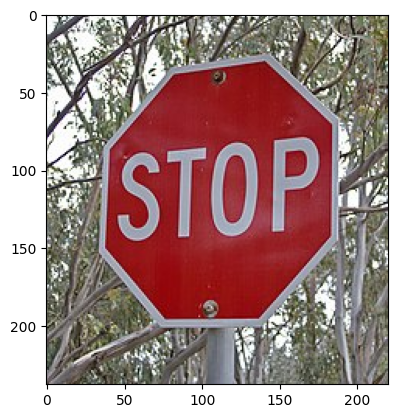

In [80]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Define the base directory for images
base_image_dir = '/home/tom/apps/python-envs/data/'

# Test the classifier on an additional image
test_image_prediction = classify_image(os.path.join(base_image_dir, 'STOP_sign.jpg'))



if test_image_prediction == 1:
    test_image_prediction='stop'

else:
    test_image_prediction='not_stop'

print("Test Image Prediction:", test_image_prediction)

# Load the image
img = mpimg.imread(os.path.join(base_image_dir, 'STOP_sign.jpg'))

# Display the image
plt.imshow(img)

# Show the plot
plt.show()
